In [1]:
"*ein: http://127.0.0.1:8899/make_figs.ipynb*"
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*"))

SyntaxError: invalid syntax (<ipython-input-1-63a19210c978>, line 2)

In [1]:
%pylab inline
import os,sys
import pickle
from importlib import reload
#sys.path.append(os.environ["CFDGITPY"])
#sys.path.append(os.environ["CRICKFISHER"] + "/code")
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft

Populating the interactive namespace from numpy and matplotlib


In [2]:
PLOT = True # Whether to actually make the plots

In [33]:
import boulder;                         reload(boulder)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_fig_tools as fpft; reload(fpft);
import fisher_plumes as fp;             reload(fp)
FisherPlumes = fp.FisherPlumes

INFO:boulder:
Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


In [34]:
import fisher_plumes_tools as fpt; reload(fpt);
#import fisher_plumes_figs  as fpf; reload(fpf);
import fisher_plumes       as fp;  reload(fp);
FisherPlumes = fp.FisherPlumes

force_reload = True
if force_reload or ('Fbw' not in locals()):
    pairs_mode = "unsigned"
    Fbw = FisherPlumes("boulder16", which_coords = [(0.45, 0.5)], py_mode = "relative", suffix = 'wideDomain.old',
                       pairs_mode = pairs_mode,
                       n_bootstraps = 10,
                       random_seed  = 0)
else:
    Fbw = FisherPlumes(Fbw)
    
data = {
    #"bb":Fbb,
    "bw":Fbw,
    #"bw1":Fbw1,
#    "w2":Fw2,
}

           fisher_plumes 2022/10/07 17:15:12     INFO: ****** LOADING sim_name='boulder16' ******


     fisher_plumes_tools 2022/10/07 17:15:12     INFO: Using relative py coordinates.


     fisher_plumes_tools 2022/10/07 17:15:12     INFO: Loading data from file_name='Re100_0_5mm_50Hz_16source_wideDomain.old.h5'.


INFO:boulder:
Re100_0_5mm_50Hz_16source_wideDomain.old.h5 <BoulderSimulationData>
x_lim: [0.0, 0.5]
y_lim: [-0.21125, 0.21125]
x-y Dimensions: [0.5    0.4225]
x-range: 0.000, 0.001 ... 0.500 (1001 points)
y-range: 0.211, 0.211 ... -0.211 (846 points)
t-range: 0.000, 0.020 ... 60.000 (3001 points)
fs: 50 Hz
Sources:
  0: =    c1a @ (x = +0, y = +0.00375)
  1: =    c1b @ (x = +0, y = -0.00375)
  2: =    c2a @ (x = +0, y = +0.01125)
  3: =    c2b @ (x = +0, y = -0.01125)
  4: =    c3a @ (x = +0, y = +0.01875)
  5: =    c3b @ (x = +0, y = -0.01875)
  6: =    c4a @ (x = +0, y = +0.02625)
  7: =    c4b @ (x = +0, y = -0.02625)
  8: =    c5a @ (x = +0, y = +0.03375)
  9: =    c5b @ (x = +0, y = -0.03375)
 10: =    c6a @ (x = +0, y = +0.04125)
 11: =    c6b @ (x = +0, y = -0.04125)
 12: =    c7a @ (x = +0, y = +0.04875)
 13: =    c7b @ (x = +0, y = -0.04875)
 14: =    c8a @ (x = +0, y = +0.05625)
 15: =    c8b @ (x = +0, y = -0.05625)


     fisher_plumes_tools 2022/10/07 17:15:12  WARNING: Doubling y coordinates because they were wrong in the original data.


INFO:boulder:Mapped coordinate ( 0.450,  0.000) to ( 0.450,  0.000), index (900, 422), name 'x=45 cm'.


INFO:boulder:Field c1a has shape (3001, 1).


INFO:boulder:Field c1b has shape (3001, 1).


INFO:boulder:Field c2a has shape (3001, 1).


INFO:boulder:Field c2b has shape (3001, 1).


INFO:boulder:Field c3a has shape (3001, 1).


INFO:boulder:Field c3b has shape (3001, 1).


INFO:boulder:Field c4a has shape (3001, 1).


INFO:boulder:Field c4b has shape (3001, 1).


INFO:boulder:Field c5a has shape (3001, 1).


INFO:boulder:Field c5b has shape (3001, 1).


INFO:boulder:Field c6a has shape (3001, 1).


INFO:boulder:Field c6b has shape (3001, 1).


INFO:boulder:Field c7a has shape (3001, 1).


INFO:boulder:Field c7b has shape (3001, 1).


INFO:boulder:Field c8a has shape (3001, 1).


INFO:boulder:Field c8b has shape (3001, 1).


     fisher_plumes_tools 2022/10/07 17:16:10     INFO: Computing pairs for 16 from -112500 to 112500 using pairs_mode='unsigned'.


     fisher_plumes_tools 2022/10/07 17:16:10     INFO: Removing duplicates in pairs dictionary.


In [30]:
Fbw.pairs

{0: [(-22500, -22500),
  (-67500, -67500),
  (-82500, -82500),
  (-97500, -97500),
  (-37500, -37500),
  (-52500, -52500),
  (-112500, -112500),
  (52500, 52500),
  (37500, 37500),
  (22500, 22500),
  (97500, 97500),
  (82500, 82500),
  (67500, 67500),
  (112500, 112500),
  (7500, 7500),
  (-7500, -7500)],
 -15000: [(52500, 67500),
  (37500, 52500),
  (22500, 37500),
  (97500, 112500),
  (82500, 97500),
  (67500, 82500),
  (7500, 22500),
  (-7500, 7500),
  (-22500, -7500),
  (-112500, -97500),
  (-67500, -52500),
  (-82500, -67500),
  (-97500, -82500),
  (-37500, -22500),
  (-52500, -37500)],
 15000: [(37500, 22500),
  (22500, 7500),
  (82500, 67500),
  (67500, 52500),
  (52500, 37500),
  (112500, 97500),
  (7500, -7500),
  (-7500, -22500),
  (-22500, -37500),
  (97500, 82500),
  (-67500, -82500),
  (-82500, -97500),
  (-97500, -112500),
  (-37500, -52500),
  (-52500, -67500)],
 -30000: [(-37500, -7500),
  (-52500, -22500),
  (52500, 82500),
  (37500, 67500),
  (22500, 52500),
  (-1125

# Compute all the statistics

In [12]:
wnd_sec = 1.
dmax    = 40000
wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
[(print(k, end = ""), sys.stdout.flush(), F.compute_all_for_window(wnd = wnd[k],
                                                                   istart = istart[k],
                                                                   window = 'boxcar',
                                                                   tukey_param = 0,
                                                                   dmax = dmax if k != "bw" else 2*dmax,
                                                                   fit_amps = False,                                                                  
)) for k, F in data.items()];

bw

           fisher_plumes 2022/10/07 16:46:49     INFO: Window set to self.wnd=50.


           fisher_plumes 2022/10/07 16:46:49     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/07 16:46:49     INFO: Computing amplitude of generalized gaussian fits to λ(s).


           fisher_plumes 2022/10/07 16:46:49     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/07 16:46:49     INFO: Computing lambdas.


           fisher_plumes 2022/10/07 16:46:49     INFO: Creating pooling functions.


           fisher_plumes 2022/10/07 16:46:49     INFO: Computing p-values.


           fisher_plumes 2022/10/07 16:46:58     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/07 16:46:58     INFO: Using 11 distances <= 80000


           fisher_plumes 2022/10/07 16:46:58     INFO: Computed λ for 26 frequencies and 11 distances and 11 bootstraps.


           fisher_plumes 2022/10/07 16:46:58     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/07 16:46:59    DEBUG: self.fit_params.shape=(11, 26, 2).


# Figure showing an example plume and correlations

In [15]:
save_fields = False
if save_fields:
    t = 40
    for F, name in zip([Fbw], ["wide"]):
        print(F.sim0.dimensions)
        for fld in F.sim0.fields:
            sfx = fld[-3:]
            fld_data  = F.sim0.snapshot(fld, t)
            file_name = os.path.join("data", f"{sfx}_{name}_t{t:g}.p")
            with open(file_name,"wb") as f:
                pickle.dump(fld_data, f)
                print(f"Wrote data for {fld} @ {t=} to {file_name}")

def load_field(fld, t, name='wide', data_dir='./data'):
    file_name = f"{fld}_{name}_t{t:g}.p"
    full_file = os.path.join(data_dir, file_name)
    print(f"Loading {fld=} at {t=:g} for {name=} from {full_file=}.")
    return np.load(os.path.join(data_dir, file_name), allow_pickle=True).T                

In [21]:
F.rho[15000].shape

(11, 26, 1785)

In [16]:
t_snapshot = 40
fields = {(i,ab,name): load_field(f"c{i}{ab}", t_snapshot, name=name) for i in range(1,9) for ab in "ab" for name in ['wide']};

Loading fld='c1a' at t=40 for name='wide' from full_file='./data/c1a_wide_t40.p'.
Loading fld='c1b' at t=40 for name='wide' from full_file='./data/c1b_wide_t40.p'.
Loading fld='c2a' at t=40 for name='wide' from full_file='./data/c2a_wide_t40.p'.
Loading fld='c2b' at t=40 for name='wide' from full_file='./data/c2b_wide_t40.p'.
Loading fld='c3a' at t=40 for name='wide' from full_file='./data/c3a_wide_t40.p'.
Loading fld='c3b' at t=40 for name='wide' from full_file='./data/c3b_wide_t40.p'.


Loading fld='c4a' at t=40 for name='wide' from full_file='./data/c4a_wide_t40.p'.
Loading fld='c4b' at t=40 for name='wide' from full_file='./data/c4b_wide_t40.p'.
Loading fld='c5a' at t=40 for name='wide' from full_file='./data/c5a_wide_t40.p'.
Loading fld='c5b' at t=40 for name='wide' from full_file='./data/c5b_wide_t40.p'.
Loading fld='c6a' at t=40 for name='wide' from full_file='./data/c6a_wide_t40.p'.
Loading fld='c6b' at t=40 for name='wide' from full_file='./data/c6b_wide_t40.p'.
Loading fld='c7a' at t=40 for name='wide' from full_file='./data/c7a_wide_t40.p'.
Loading fld='c7b' at t=40 for name='wide' from full_file='./data/c7b_wide_t40.p'.
Loading fld='c8a' at t=40 for name='wide' from full_file='./data/c8a_wide_t40.p'.
Loading fld='c8b' at t=40 for name='wide' from full_file='./data/c8b_wide_t40.p'.


Wrote figs/plumes_demo.pdf.


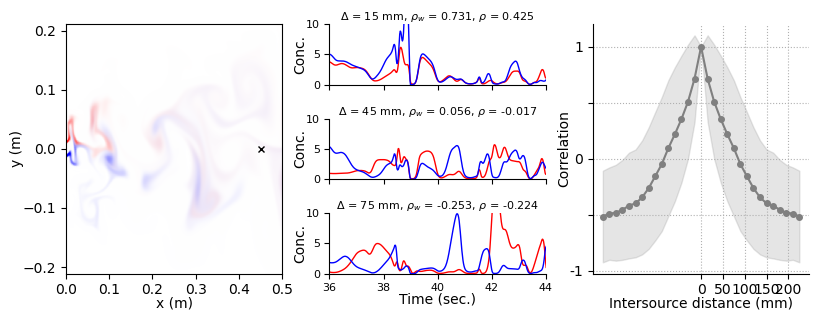

In [24]:
import boulder
reload(fpft)
wnd = Fbw.wnd
name = 'wide'
F = {'wide':Fbw}[name]
figure(figsize=(8,3))
gs = GridSpec(3,3)
ax_plume = subplot(gs[:,0])
pp = boulder.concs2rgb(fields[1,"a",name], fields[1,"b",name])
dx, dy = F.sim0.dimensions
ax_plume.matshow(pp, extent = [0, dx, -dy/2, dy/2])
px, py = F.sim0.get_used_probe_coords()[0]
ax_plume.plot(px, py, "kx", markersize=5)
ax_plume.xaxis.set_ticks_position('bottom')
ax_plume.axis("auto")
xlabel("x (m)", labelpad=-1)
ylabel("y (m)", labelpad=-1)
ax_plume.set_yticks(arange(-0.2,0.21,0.1) if 'wide' in name else arange(-0.1,0.11,0.1))

dists = np.array(sorted(Fbw.sims.keys()))
dists = dists[dists>0]
which_idists = [0,1,2]
tlim = np.array([-4,4]) + t_snapshot
ysc  = 100
yl   = (0,10)
ax_trace = []
for i, di in enumerate(which_idists):
    ax_trace.append(subplot(gs[i,1]))
    a = F.sims[dists[di]].data.flatten()*ysc
    b = F.sims[-dists[di]].data.flatten()*ysc
    t = F.sim0.t
    ax_trace[-1].plot(t,a,color="r", label=f"{dists[di]}", linewidth=1)
    ax_trace[-1].plot(t,b,color="b", label=f"-{dists[di]}", linewidth=1)
    (i < 2) and ax_trace[-1].set_xticklabels([])
    (i ==2) and ax_trace[-1].set_xlabel("Time (sec.)", labelpad=-1)
    fpft.spines_off(ax_trace[-1])
    ax_trace[-1].set_xlim(*tlim)
    #ax_trace[-1].set_xticks(arange(tlim[0],tlim[-1]+1,1))
    ax_trace[-1].set_ylim(*yl)
    ax_trace[-1].set_yticks(arange(0,11,5))
    ax_trace[-1].tick_params(axis='both', labelsize=8)
    ax_trace[-1].set_ylabel("Conc.", labelpad=-1)
    #ax_trace[-1].legend(frameon=False,labelspacing=0,fontsize=6)
    wndf = lambda x: x[(t>=tlim[0])*(t<tlim[-1])]
    aw, bw = wndf(a), wndf(b)
    ρ_w = corrcoef(aw,bw)[0,1]
    ρ   = corrcoef(a, b)[0,1]
    # text(tlim[0], yl[1], f"$\Delta$ = {2*dists[di]/1000:g} mm\n$\\rho$ = {ρ_w:1.3f} (window)\n$\\rho$ = {ρ:1.3f} (all)", fontsize=6, verticalalignment="top")
    title(f"$\Delta$ = {2*dists[di]/1000:g} mm, $\\rho_w$ = {ρ_w:1.3f}, $\\rho$ = {ρ:1.3f}", fontsize=8, verticalalignment="top")
    
    
ax_corr_dist = subplot(gs[:,-1])
rho   = F.rho
dists = np.array(sorted(list(rho.keys()))) 
rho   = {d:rho[d][0] for d in dists} # Take the raw data, not the bootstraps
rhom  = np.array([np.mean(np.sum(rho[d],axis=0)) for d in dists])
rhos  = np.array([ np.std(np.sum(rho[d],axis=0)) for d in dists])
col   = "gray"
plt.fill_between(dists/1000, rhom-rhos,rhom+rhos, color=fpft.set_alpha(mpl.colors.to_rgba(col),0.2));
fpft.pplot(dists/1000, rhom , "o-", markersize=4,color=col);
ax_corr_dist.set_xticks(arange(0,201,50))
ax_corr_dist.grid(True, linestyle=":")
ax_corr_dist.set_yticks(arange(-1,1.1,0.5))
ax_corr_dist.set_yticklabels(["-1","","0","","1"])
ax_corr_dist.set_ylabel("Correlation",labelpad=-1)
ax_corr_dist.set_xlabel("Intersource distance (mm)", labelpad=-1)
tight_layout(pad=0,w_pad=0,h_pad=1)
file_name = f"figs/plumes_demo.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Figure showing the distribution of correlations

Wrote figs/corr_components_bw.pdf.


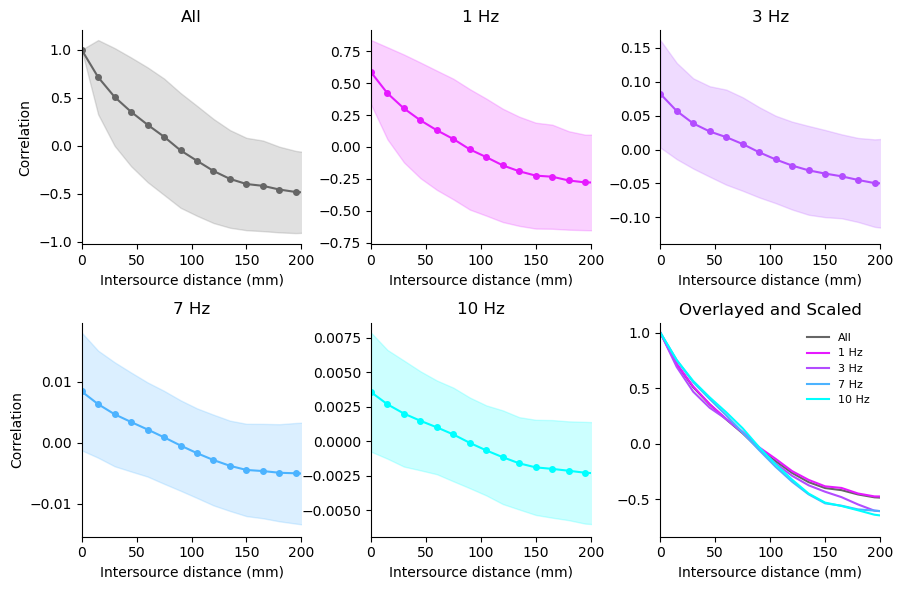

In [11]:
which_freqs = [1,3,7,10]
labs = [f"{f} Hz" for f in which_freqs]
cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f/10) for f in which_freqs])})
slices = {}
for k, F in data.items():
    if k in ["bw"]:
        slices[k] = {"All":slice(1,10000)}
        slices[k].update({l:slice(fi, fi+1) for l, fi in zip(labs, F.freqs2inds(which_freqs))})
        ax = cff.plot_correlations(F.rho, F.wnds[0], xl = (0, 120), slices=slices[k], cols=cols, n_rows = 2, plot_order = ["All"] + labs)
        [(axi.set_xlabel("Intersource distance (mm)"), axi.set_xticks(arange(0,201,50))) for axi in ax]
        file_name = f"figs/corr_components_{k}.pdf"
        PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

Wrote figs/coef_vs_coef_bw.pdf.


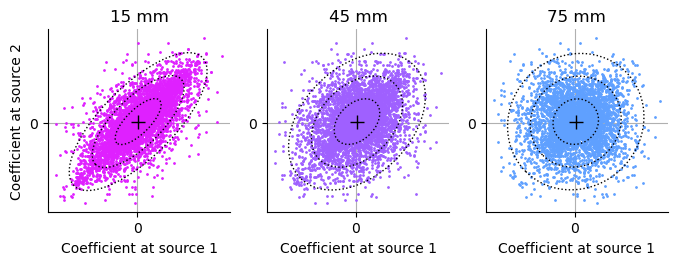

In [12]:
reload(cff)
which_freq = 5
name = "bw"
F = data[name]
ifreq = F.freqs2inds([which_freq])[0]
cff.plot_coef1_vs_coef2([F.ss, F.cc],
                        F.wnds[0],
                        ifreq,
                        F.pairs)
file_name = f"figs/coef_vs_coef_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Asymmetric Laplacian Fits

d=15000 @ Freq #  10: -np.log10(p) = 31.977
d=30000 @ Freq #  10: -np.log10(p) = 18.155
d=45000 @ Freq #  10: -np.log10(p) = 9.682


/camp/home/tootoos/working/tootoos/git/crick-fisher/code/crick_fisher_figs.py:163: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(-np.log10(p), #+np.min(p[p>0])/10),


Wrote figs/alap_fits_bw.pdf.


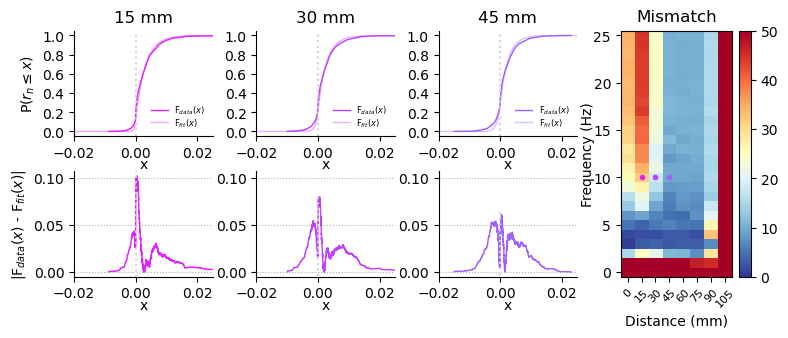

In [13]:
reload(cff)
d = np.array(list(F.rho.keys()))
d = np.sort(d[d>0])
cff.plot_alaplace_fits(F.rho, F.la, F.mu, F.pvals, d[:3], F.wnds[0],
                       ifreq_lim = [],
                       xl = [-0.02,0.025],
                       which_ifreq = 10,
                       figsize=(8,3.5), vmax=50,
                       cm_heat = cm.RdYlBu_r,
                       fs = F.fs,
                       plot_dvals=True)
file_name = f"figs/alap_fits_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the figure showing λ(s)

Wrote figs/la_vs_s_fits_bw.pdf.


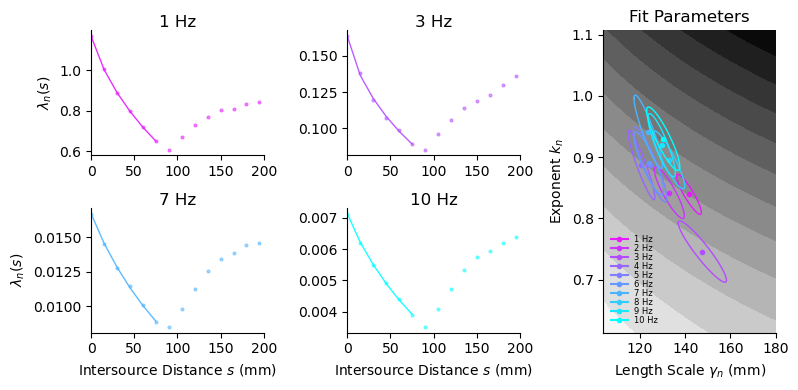

In [110]:
reload(cfft)
reload(cff)
ax = cff.plot_la_gen_fits_vs_distance(Fbw.la, Fbw.wnds[0], Fbw.dd_gen, Fbw.params_gen, fs = 50,
                                      xl = (0,200), figsize=(8,4), legloc = 'right',
                                      which_ifreqs = [1,3,7,10],
                                      contours_dist = 1,
                                      plot_overlay=False)
[(axi.set_xticks(arange(0,201,50)), (i>1) and axi.set_xlabel("Intersource Distance $s$ (mm)")) for i, axi in enumerate(ax[:4])]
file_name = f"figs/la_vs_s_fits_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

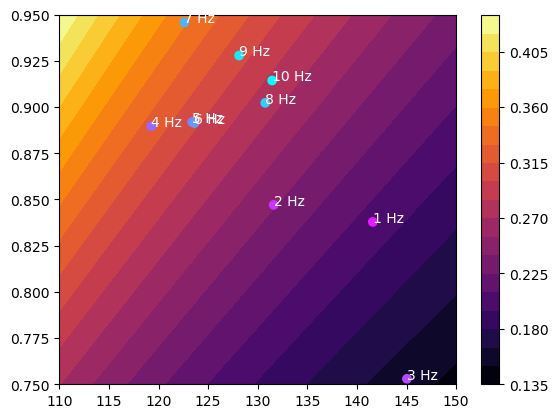

In [51]:
K, Γ = meshgrid(linspace(0.75,0.95,101),linspace(110,150,201))
sn = 1
I = (K / Γ)**2 * ((sn ** (K-1))**2)/(np.exp(sn**K)-1)*10000
contourf((I.T), 20, extent=[np.min(Γ), np.max(Γ), np.min(K), np.max(K)],cmap=cm.inferno)
γ = Fbw.params_gen[1][1:11]/1000
k = Fbw.params_gen[2][1:11]
gca().scatter(γ, k, c = [cm.cool_r(i/10) for i in range(1,11)])
[text(γi, ki, f"{fi} Hz", color="w") for (γi, ki, fi) in zip(γ,k,range(1,11))]
axis("auto")
colorbar()

# Plot the Fisher information

In [52]:
reload(cft)
p = Fbw.params_gen[:,3]
cft.compute_fisher_information_for_gen_exp_decay(70000,*p[1:])

4.938950910664408e-11

Wrote figs/fisher_info_bw.pdf.


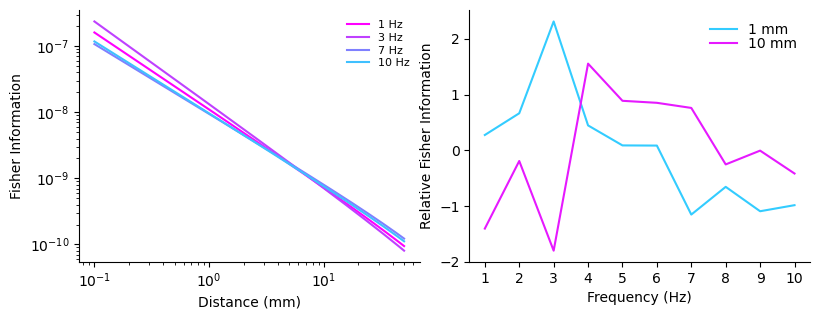

In [53]:
reload(cft)
reload(cff)
figure(figsize=(8,3))
cff.plot_fisher_information(Fbw.params_gen[1:].T, # Skip the amplitude parameter
                            Ifun = cft.compute_fisher_information_for_gen_exp_decay,
                            d_lim=[1,10000],
                            d_ranges = [[100,50000]],#,[1000,50000]],
                            d_scale = 1000,
                            which_ifreqs = [1,3,7,10],
                            fi_scale = 1, plot_fun = plt.loglog,
                            plot_for_dists=([1000,10000], list(range(1,11)), plt.semilogy, [cm.cool(0.2), cm.cool(0.9)]),
)
gca().set_xticks(arange(1,11));
file_name = f"figs/fisher_info_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Fourier transforms to get a sense of the spectra

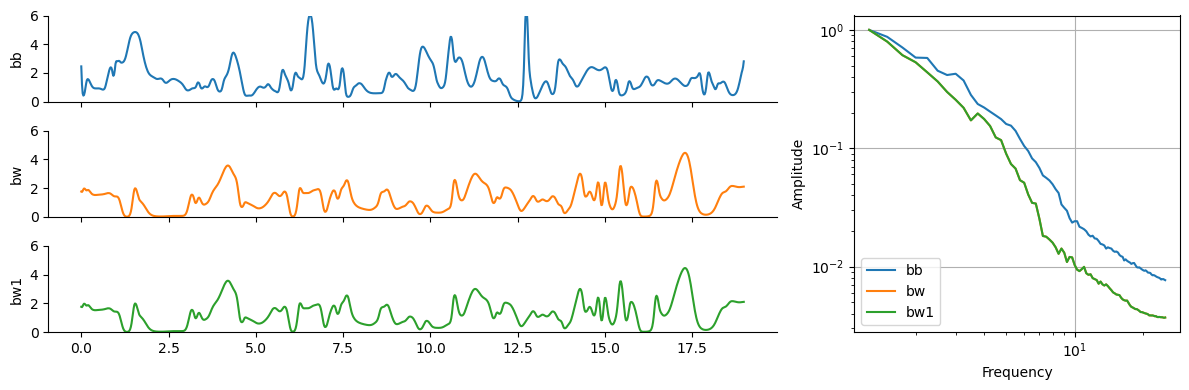

In [44]:
mid_sim = lambda F: F.sims[F.yvals[len(F.yvals)//2]].data.flatten()

gs = GridSpec(len(data),3)
figure(figsize=(12,4))
for i, (k, F) in enumerate(data.items()):
    p = mid_sim(F)
    p /= std(p)
    p[p<0] = 0
    t = arange(len(p))/F.fs
#    if i == 0:
#        ax = subplot(gs[:,0])
    subplot(gs[i,:2])
    plot(t[(t>t//2-10)&(t<t//2+10)],p[(t>t//2-10)&(t<t//2+10)], color=f"C{i}")
    (i != len(data)-1) and gca().set_xticklabels([])
    ylabel(k)
    ylim(0,6)
    [gca().spines[w].set_visible(False) for w in ['top','right']]
    if i == 0:
        ax_fft = subplot(gs[:,-1])
    w  = len(p)//15
    f,t,Z = stft(p[:10*w], fs = F.fs, nperseg=w)
    a = mean(abs(Z),axis=1)
    ax_fft.loglog(f[f>1], a[f>1]/a[f>1][0], color=f"C{i}", label=k)

ax_fft.legend(loc="lower left")
ax_fft.set_xlabel("Frequency")
ax_fft.set_ylabel("Amplitude")
ax_fft.grid(True)
tight_layout()